# No outliers data

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

## 5 fold

In [ ]:
norm_gen_data = os.path.join(os.getcwd(), "input_data", "NoOutliers_filtered_gene_expression.csv")
normgendf = pd.read_csv(norm_gen_data)

metadata = os.path.join(os.getcwd(), "input_data", "metadata_randomGroup.csv")
metadata_df = pd.read_csv(metadata)

normgendf.rename(columns={'Unnamed: 0': 'mRNA'}, inplace=True)
merged_df = pd.merge(normgendf, metadata_df, on="mRNA", how="left")
merged_df = merged_df.dropna(subset=["ER_y"])

feature_cols = [col for col in merged_df.columns if col.startswith("ENSG")]
param_grid = {'C': np.logspace(-3, 3, 7)}  # 0.001, 0.01, 0.1, 1, 10, 100, 1000

groups = np.sort(merged_df["Group"].unique())

merged_df["ER_y"] = merged_df["ER_y"].astype(str)

# List to store outer test accuracies for each group fold
outer_test_accuracies = []
# Lists to store all true labels and predictions for an overall confusion matrix
all_true = []
all_pred = []

# Loop over each group as the test fold
for k in groups:
    print(f"\nProcessing fold for Group {k}")
    
    # Split data: test set = rows with current group k, training set = remaining rows
    train_df = merged_df[merged_df["Group"] != k].copy()
    test_df = merged_df[merged_df["Group"] == k].copy()
    
    # Use only the numeric gene expression features as predictors
    X_train = train_df[feature_cols]
    y_train = train_df["ER_y"]
    X_test = test_df[feature_cols]
    y_test = test_df["ER_y"]
    
    # Initialize logistic regression with L1 penalty (LASSO)
    lasso_logistic = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
    
    # Set up GridSearchCV with 5-fold cross-validation on the training set
    grid_search = GridSearchCV(estimator=lasso_logistic, param_grid=param_grid, cv=5, scoring='accuracy')
    
    # Fit GridSearchCV on the training data
    grid_search.fit(X_train, y_train)
    
    best_C = grid_search.best_params_['C']
    best_cv_score = grid_search.best_score_
    print("Best C value:", best_C)
    print("Inner 5-fold CV accuracy (average on training):", best_cv_score)
    
    y_pred = grid_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test set accuracy:", test_accuracy)
    outer_test_accuracies.append(test_accuracy)
    
    all_true.extend(y_test.tolist())
    all_pred.extend(y_pred.tolist())
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for Group {k}:")
    print(cm)
    
    # Visualize the confusion matrix using matplotlib
    # plt.figure()
    # plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # plt.title(f'Confusion Matrix for Group {k}')
    # plt.colorbar()
    # tick_marks = np.arange(len(np.unique(merged_df["ER_y"])))
    # plt.xticks(tick_marks, np.unique(merged_df["ER_y"]))
    # plt.yticks(tick_marks, np.unique(merged_df["ER_y"]))
    # plt.xlabel('Predicted label')
    # plt.ylabel('True label')
    # plt.show()



Processing fold for Group 1
Best C value: 0.1
Inner 5-fold CV accuracy (average on training): 0.9416143156291643
Test set accuracy: 0.9420289855072463
Confusion Matrix for Group 1:
[[ 26   5]
 [  3 104]]

Processing fold for Group 2
Best C value: 0.1
Inner 5-fold CV accuracy (average on training): 0.9379650855228354
Test set accuracy: 0.975
Confusion Matrix for Group 2:
[[29  2]
 [ 1 88]]

Processing fold for Group 3
Best C value: 0.1
Inner 5-fold CV accuracy (average on training): 0.9435941366837998
Test set accuracy: 0.9492753623188406
Confusion Matrix for Group 3:
[[ 23   4]
 [  3 108]]

Processing fold for Group 4
Best C value: 0.1
Inner 5-fold CV accuracy (average on training): 0.9416143156291643
Test set accuracy: 0.9565217391304348
Confusion Matrix for Group 4:
[[33  4]
 [ 2 99]]

Processing fold for Group 5
Best C value: 0.1
Inner 5-fold CV accuracy (average on training): 0.9512431669899488
Test set accuracy: 0.9322033898305084
Confusion Matrix for Group 5:
[[21  3]
 [ 5 89]]


## Overall performance metrics with conufion matrix 


Outer fold test accuracies: [0.9420289855072463, 0.975, 0.9492753623188406, 0.9565217391304348, 0.9322033898305084]
Average outer test accuracy: 0.951005895357406

Overall Confusion Matrix:
[[132  18]
 [ 14 488]]


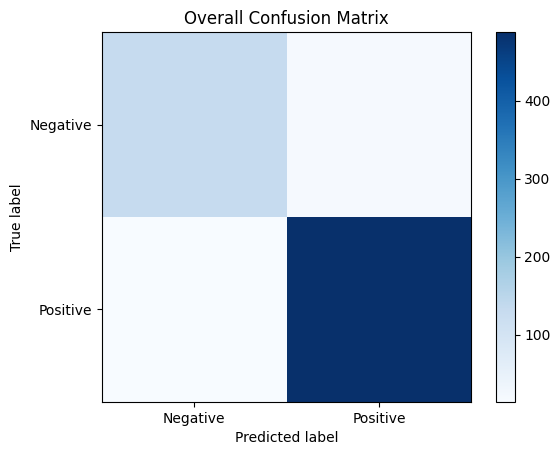

In [ ]:
print("\nOuter fold test accuracies:", outer_test_accuracies)
print("Average outer test accuracy:", np.mean(outer_test_accuracies))

# Compute and display the overall confusion matrix across all folds
overall_cm = confusion_matrix(all_true, all_pred)
print("\nOverall Confusion Matrix:")
print(overall_cm)

# Visualize the overall confusion matrix using matplotlib
plt.figure()
plt.imshow(overall_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Overall Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(merged_df["ER_y"])))
plt.xticks(tick_marks, np.unique(merged_df["ER_y"]))
plt.yticks(tick_marks, np.unique(merged_df["ER_y"]))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# group 6 prediction

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

norm_gen_data = os.path.join(os.getcwd(), "input_data", "NoOutliers_filtered_gene_expression.csv")
normgendf = pd.read_csv(norm_gen_data)
metadata = os.path.join(os.getcwd(), "input_data", "metadata_randomGroup.csv")
metadata_df = pd.read_csv(metadata)

normgendf.rename(columns={'Unnamed: 0': 'mRNA'}, inplace=True)
merged_df_full = pd.merge(normgendf, metadata_df, on="mRNA", how="left")

# For training, drop rows with missing ER_y (this will remove group 6 if they have missing ER_y)
train_df = merged_df_full.dropna(subset=["ER_y"]).copy()

# For testing, we want group 6 rows even if ER_y is missing (to predict them)
test_df = merged_df_full[merged_df_full["Group"] == 6].copy()

# Convert the target variable to string for training
train_df["ER_y"] = train_df["ER_y"].astype(str)

# Select only the numeric gene expression features (columns starting with "ENSG")
feature_cols = [col for col in merged_df_full.columns if col.startswith("ENSG")]

# Set up a grid of C values for logistic regression (L1 penalty)
param_grid = {'C': np.logspace(-3, 3, 7)}  # 0.001, 0.01, 0.1, 1, 10, 100, 1000

# Initialize logistic regression with L1 penalty (LASSO)
lasso_logistic = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Set up GridSearchCV with 5-fold cross-validation on the training set
grid_search = GridSearchCV(estimator=lasso_logistic, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model using the training data (only rows with non-missing ER_y)
X_train = train_df[feature_cols]
y_train = train_df["ER_y"]
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']
best_cv_score = grid_search.best_score_
print("Best C value:", best_C)
print("Inner 5-fold CV accuracy (average on training):", best_cv_score)

# Predict the ER_y values for group 6 (which are missing in the training set)
X_test = test_df[feature_cols]
predictions = grid_search.predict(X_test)

# Append the predictions to the test dataframe
test_df = test_df.copy()  
test_df["ER_y_pred"] = predictions

metadata_df_group6 = metadata_df[metadata_df["Group"] == 6]

# Merge the predicted values with the group 6 metadata using 'mRNA' as key.
group6_results = pd.merge(metadata_df_group6, test_df[['mRNA', 'ER_y_pred']], on="mRNA", how="left")
print("\nPredicted ER_y values for Group 6 (merged with metadata):")
print(group6_results)

output_csv = os.path.join(os.getcwd(), "prediction_data", "group6_predictions_noutliers.csv")
group6_results.to_csv(output_csv, index=False)
print(f"\nThe predictions for Group 6 have been saved to: {output_csv}")


Best C value: 0.1
Inner 5-fold CV accuracy (average on training): 0.9417263652378157

Predicted ER_y values for Group 6 (merged with metadata):
                             mRNA  PAM50  TumorPurity  ProliferationScore  \
0    TCGA-BH-A0HQ-01A-11R-A034-07   LumA         0.52           -0.821974   
1    TCGA-A1-A0SD-01A-11R-A115-07   LumA         0.51           -0.853940   
2    TCGA-A2-A0CQ-01A-21R-A034-07   LumA         0.80           -0.218021   
3    TCGA-A2-A0CS-01A-11R-A115-07   LumA         0.55           -0.393590   
4    TCGA-A2-A0YC-01A-11R-A109-07   LumA         0.65           -0.232119   
..                            ...    ...          ...                 ...   
106  TCGA-D8-A1XC-01A-11R-A14D-07   LumA         0.89           -0.032453   
107  TCGA-E2-A14T-01A-11R-A115-07   LumA          NaN           -0.153636   
108  TCGA-E2-A1LG-01A-21R-A14M-07  Basal         0.77            0.255114   
109  TCGA-E9-A54X-01A-11R-A266-07   LumB          NaN            0.131802   
110  TCGA

# on filtered data with outliers 

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

filtered_df = pd.read_csv("input_data/filtered_gene_expression.csv")
filtered_df.rename(columns={'Unnamed: 0': 'mRNA'}, inplace=True)

metadata_path = os.path.join(os.getcwd(), "input_data", "metadata_randomGroup.csv")
metadata_df = pd.read_csv(metadata_path)

merged_df = pd.merge(filtered_df, metadata_df, on="mRNA", how="left")
merged_df = merged_df.dropna(subset=["ER"])
merged_df["ER"] = merged_df["ER"].astype(str)

# Select only the numeric gene expression features (columns starting with "ENSG")
feature_cols = [col for col in merged_df.columns if col.startswith("ENSG")]

# Set up a grid of C values for logistic regression with L1 penalty (LASSO)
param_grid = {'C': np.logspace(-3, 3, 7)}  

# Get the unique groups for cross-validation (assumed to be numbered 1, 2, ...)
groups = np.sort(merged_df["Group"].unique())

# Initialize storage for outer fold accuracies, overall true labels, and predictions by group
outer_test_accuracies = []
all_true = []
all_pred = {}  # Dictionary to store predictions for each group

for k in groups:
    print(f"\nProcessing fold for Group {k}")
    
    # Split data: test set = rows with current group k, training set = remaining rows
    train_df = merged_df[merged_df["Group"] != k].copy()
    test_df = merged_df[merged_df["Group"] == k].copy()
    
    X_train = train_df[feature_cols]
    y_train = train_df["ER"]
    X_test = test_df[feature_cols]
    y_test = test_df["ER"]
    
    lasso_logistic = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
    grid_search = GridSearchCV(estimator=lasso_logistic, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_C = grid_search.best_params_['C']
    best_cv_score = grid_search.best_score_
    print("Best C value:", best_C)
    print("Inner 5-fold CV accuracy (average on training):", best_cv_score)
    
    # Evaluate the best model on the outer test set
    y_pred = grid_search.predict(X_test)
    fold_accuracy = accuracy_score(y_test, y_pred)
    print("Test set accuracy:", fold_accuracy)
    outer_test_accuracies.append(fold_accuracy)
    all_true.extend(y_test.tolist())
    all_pred[k] = y_pred  


Processing fold for Group 1
Best C value: 1000.0
Inner 5-fold CV accuracy (average on training): 0.9302944806912361
Test set accuracy: 0.9290780141843972

Processing fold for Group 2
Best C value: 0.1
Inner 5-fold CV accuracy (average on training): 0.9179149291075896
Test set accuracy: 0.959349593495935

Processing fold for Group 3
Best C value: 0.1
Inner 5-fold CV accuracy (average on training): 0.9356873315363881
Test set accuracy: 0.9370629370629371

Processing fold for Group 4
Best C value: 0.1
Inner 5-fold CV accuracy (average on training): 0.9283900546640804
Test set accuracy: 0.9432624113475178

Processing fold for Group 5
Best C value: 0.1
Inner 5-fold CV accuracy (average on training): 0.9396663886572144
Test set accuracy: 0.9032258064516129


## group 6 prediction


Overall Confusion Matrix:
[[139  23]
 [ 21 489]]

Outer fold test accuracies: [0.9290780141843972, 0.959349593495935, 0.9370629370629371, 0.9432624113475178, 0.9032258064516129]
Average outer test accuracy: 0.9343957525084801


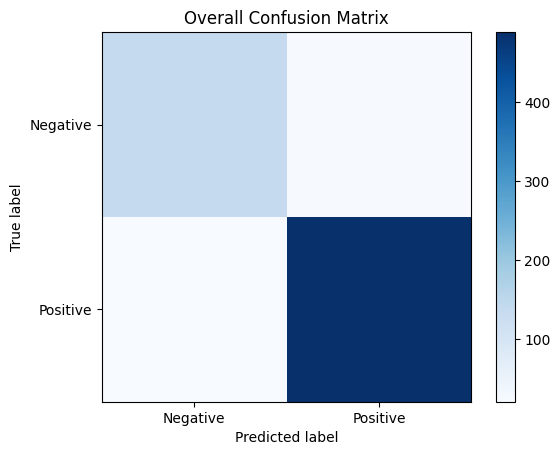

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Compute the overall confusion matrix across all groups
# (Concatenate predictions from each group)
all_pred_concat = np.concatenate(list(all_pred.values()))
overall_cm = confusion_matrix(all_true, all_pred_concat)
print("\nOverall Confusion Matrix:")
print(overall_cm)

print("\nOuter fold test accuracies:", outer_test_accuracies)
print("Average outer test accuracy:", np.mean(outer_test_accuracies))

# Visualize the overall confusion matrix
plt.figure()
plt.imshow(overall_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Overall Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(merged_df["ER"])))
plt.xticks(tick_marks, np.unique(merged_df["ER"]))
plt.yticks(tick_marks, np.unique(merged_df["ER"]))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [ ]:
# Load the filtered gene expression data
filtered_df = pd.read_csv("input_data/filtered_gene_expression.csv")
filtered_df.rename(columns={'Unnamed: 0': 'mRNA'}, inplace=True)

# Load the metadata
metadata_path = os.path.join(os.getcwd(), "input_data", "metadata_randomGroup.csv")
metadata_df = pd.read_csv(metadata_path)

# Merge the filtered data with metadata on 'mRNA'
# Create a full merged dataframe without dropping any rows so that group 6 remains available
merged_df_full = pd.merge(filtered_df, metadata_df, on="mRNA", how="left")

# For training, drop rows where the target "ER" is missing 
# (this will remove group 6 rows if they have missing ER values)
train_df = merged_df_full.dropna(subset=["ER"]).copy()

# For testing, we select group 6 rows (even if "ER" is missing)
test_df = merged_df_full[merged_df_full["Group"] == 6].copy()

# Ensure the target variable in the training set is consistently typed as string
train_df["ER"] = train_df["ER"].astype(str)

# Select only the numeric gene expression features (columns starting with "ENSG")
feature_cols = [col for col in merged_df_full.columns if col.startswith("ENSG")]

# Set up a grid of C values for logistic regression (L1 penalty)
param_grid = {'C': np.logspace(-3, 3, 7)}  # 0.001, 0.01, 0.1, 1, 10, 100, 1000

# Initialize logistic regression with L1 penalty (LASSO)
lasso_logistic = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Set up GridSearchCV with 5-fold cross-validation on the training set
grid_search = GridSearchCV(estimator=lasso_logistic, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model using the training data (only rows with non-missing "ER")
X_train = train_df[feature_cols]
y_train = train_df["ER"]
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']
best_cv_score = grid_search.best_score_
print("Best C value:", best_C)
print("Inner 5-fold CV accuracy (average on training):", best_cv_score)

# Predict the ER values for group 6
X_test = test_df[feature_cols]
predictions = grid_search.predict(X_test)

# Append the predictions to the test dataframe
test_df = test_df.copy()  
test_df["ER_pred"] = predictions

# Use one-liner to filter group 6 metadata (which contains the missing ER values)
metadata_df_group6 = metadata_df[metadata_df["Group"] == 6]

# Merge the predicted values with the group 6 metadata using 'mRNA' as the key
group6_results = pd.merge(metadata_df_group6, test_df[['mRNA', 'ER_pred']], on="mRNA", how="left")
print("\nPredicted ER values for Group 6 (merged with metadata):")
print(group6_results)

output_csv = os.path.join(os.getcwd(), "prediction data", "group6_predictions_filtered.csv")
group6_results.to_csv(output_csv, index=False)
print(f"\nThe predictions for Group 6 have been saved to: {output_csv}")


Best C value: 0.1
Inner 5-fold CV accuracy (average on training): 0.9285351022664455

Predicted ER values for Group 6 (merged with metadata):
                             mRNA  PAM50  TumorPurity  ProliferationScore  \
0    TCGA-BH-A0HQ-01A-11R-A034-07   LumA         0.52           -0.821974   
1    TCGA-A1-A0SD-01A-11R-A115-07   LumA         0.51           -0.853940   
2    TCGA-A2-A0CQ-01A-21R-A034-07   LumA         0.80           -0.218021   
3    TCGA-A2-A0CS-01A-11R-A115-07   LumA         0.55           -0.393590   
4    TCGA-A2-A0YC-01A-11R-A109-07   LumA         0.65           -0.232119   
..                            ...    ...          ...                 ...   
106  TCGA-D8-A1XC-01A-11R-A14D-07   LumA         0.89           -0.032453   
107  TCGA-E2-A14T-01A-11R-A115-07   LumA          NaN           -0.153636   
108  TCGA-E2-A1LG-01A-21R-A14M-07  Basal         0.77            0.255114   
109  TCGA-E9-A54X-01A-11R-A266-07   LumB          NaN            0.131802   
110  TCGA-E